# Íñigo Ruiz Martínez - Abril 2023
## Participación en concurso de DrivenData.org 'Pump it Up: Data Mining the Water Table' (https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)
### Versión final con puntuación de 0.8133
El notebook se puede ejecutar sin problema si se tienen los dataframes de training y test con sus nombres originales en la misma carpeta contenedora del notebook.

Se han comentado las celdas que tardarían más y las que exportan en csv para que no haya problema en la correción.

Tiempo medio de ejecución: 40 segs.

Empezamos importantando las librerías necesarias para la realización del ejercicio:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

Ejecutamos esta celda para mostrar de una vez todas las columnas del dataframe:

In [ ]:
pd.options.display.max_columns=100

Leemos los tres datasets que nos interesan:

In [ ]:
df_training = pd.read_csv("training_set_values.csv")
df_labels = pd.read_csv("training_set_labels.csv")
df_test = pd.read_csv("test_set_values.csv")

Vemos qué pinta tiene el dataset 'labels':

In [ ]:
df_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


Vemos el tamaño de las tres tablas:

In [ ]:
print('Tamaño de tabla de training values:',df_training.shape[0])
print('Tamaño de tabla de training labels:',df_labels.shape[0])
print('Tamaño de tabla de test values:',df_test.shape[0])

Tamaño de tabla de training values: 59400
Tamaño de tabla de training labels: 59400
Tamaño de tabla de test values: 14850


Comprobamos que las bombas de la tabla labels son las mismas que de la tabla training values:

In [ ]:
print('Bombas en tabla labels\n', df_labels['id'].isin(df_training['id']).value_counts())

Bombas en tabla labels
 True    59400
Name: id, dtype: int64


Unimos los dos datasets de training: values y labels

In [ ]:
df = pd.merge(df_training, df_labels, on = "id", how = "left")
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


Fijamos el id como nuevo index:

In [ ]:
df.set_index('id',inplace=True)
df

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional


Vemos el balance de la variable objetivo:

In [ ]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Vemos la forma del dataframe:

In [ ]:
df.shape

(59400, 40)

Para ver el tipo de cada columna, y de paso los valores nulos utilizamos .info:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

Ahora examinamos los valores nulos con mayor exhaustividad y limpieza:

In [ ]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

Examinamos los valores únicos:

In [ ]:
df.nunique()

amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

Ahora vemos la información de las columnas numéricas y no numéricas:

In [ ]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [ ]:
df.describe(exclude=np.number)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


### Limpieza de columnas similares:

Examinando las columnas del dataset, vemos que **'scheme_management'** tiene 3877 valores nulos y que realmente es muy parecida a la variable **'management'** pues una indica quién opera el punto de agua, y la otra cómo es operado. Por lo tanto optaremos por eliminar la variable scheme_management y quedarnos solo con la otra que no tiene valores nulos:

La variable 'management_group' es practicamente igual, salvo que agrupa estos valores en grupos, por tanto decidimos prescindir también de ella.

In [ ]:
df['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [ ]:
df['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [ ]:
df.drop(columns=['management_group','scheme_management'], inplace = True)

Lo mismo ocurre con las columnas **'source'**, **'source_type'**, y **'source_class'**. Prácticamente misma información en las dos primeras, y en la tercera solo clasifica en grupos. Por tanto nos quedamos con la primera, que es la más completa:

In [ ]:
df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [ ]:
df['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [ ]:
df.drop(columns=['source_type','source_class'], inplace = True)

Las columnas **'water_quality'** y **'quality_group'** indican lo mismo, como la primera tiene más clasificaciones nos quedaremos con ella:

In [ ]:
df['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [ ]:
df['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [ ]:
df.drop(['quality_group'], axis = 1, inplace = True)

Vemos también que las columnas **'quantity'** y **'quantity_group'** tienen exactamente los mismos valores por lo que solo nos quedamos con una de ellas:

In [ ]:
df['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [ ]:
df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [ ]:
df.drop(['quantity_group'], axis = 1, inplace = True)

Las columnas **'waterpoint_type'** y **'waterpoint_type_group'** también son muy similares, pero en la primera al no ser agrupaciones se contiene mayor información por lo tanto es la que nos quedaremos:

In [ ]:
df['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [ ]:
df['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [ ]:
df[['waterpoint_type' , 'waterpoint_type_group']]

,waterpoint_type,waterpoint_type_group
id,,
69572,communal standpipe,communal standpipe
8776,communal standpipe,communal standpipe
34310,communal standpipe multiple,communal standpipe
67743,communal standpipe multiple,communal standpipe
19728,communal standpipe,communal standpipe
...,...,...
60739,communal standpipe,communal standpipe
27263,communal standpipe,communal standpipe
37057,hand pump,hand pump


In [ ]:
df.drop(['waterpoint_type_group'], axis = 1, inplace = True)

Respecto a las columnas **'extraction_type'**, **'extraction_type_group'** y **'extraction_type_class'** nos decidimos quedar con la primera porque es la más completa:

In [ ]:
df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [ ]:
df['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [ ]:
df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [ ]:
df.drop(['extraction_type_group', 'extraction_type_class'], axis = 1, inplace = True)

Las últimas columnas similares son las de **'payment'** y **'payment_type'** que son idénticas, por lo que nos quedamos con la segunda, pues la descripción de sus campos es más sencilla:

In [ ]:
df['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [ ]:
df['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [ ]:
df.drop(['payment'], axis = 1, inplace = True)

Eliminamos también la columna **'recorded_by'** puesto que es constante todo el dataframe:

In [ ]:
df['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [ ]:
df.drop(['recorded_by'], axis = 1, inplace = True)

Comprobamos ahora las columnas que tenemos en el dataframe, puesto que hemos eliminado 12 de ellas y por tanto simplificado el mismo:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   date_recorded      59400 non-null  object 
 2   funder             55765 non-null  object 
 3   gps_height         59400 non-null  int64  
 4   installer          55745 non-null  object 
 5   longitude          59400 non-null  float64
 6   latitude           59400 non-null  float64
 7   wpt_name           59400 non-null  object 
 8   num_private        59400 non-null  int64  
 9   basin              59400 non-null  object 
 10  subvillage         59029 non-null  object 
 11  region             59400 non-null  object 
 12  region_code        59400 non-null  int64  
 13  district_code      59400 non-null  int64  
 14  lga                59400 non-null  object 
 15  ward               59400 non-null  object 
 16  population        

### Tratamiento de las columnas con valores anómalos:

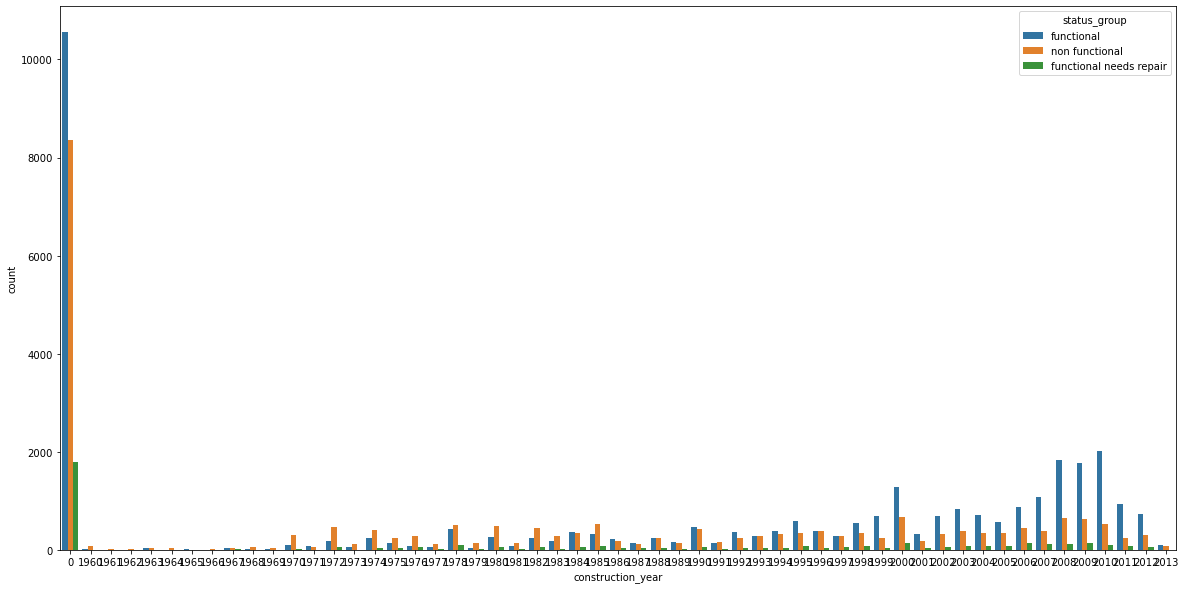

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='construction_year', hue="status_group", data=df)

In [ ]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

La columna **'construction_year'** tiene muchos valores 0. En vez de sustituirlos directamente por la media, voy a tramificarla por tramos de 5 años para no asignar todos estos valores 0 a un solo año.

Primero calculamos la media de los valores 0 del antiguo campo 'construction_year' para así calcular su media sin estos y poder asignar en el nuevo campo los 0 al valor de la media:

In [ ]:
df.loc[df['construction_year']!=0].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,38691.000000,38691.000000,38691.000000,38691.000000,38691.000000,38691.000000,38691.000000,38691.000000,38691.000000
mean,466.457534,1002.367760,35.983262,-6.235372,0.707710,15.706495,5.969786,269.799617,1996.814686
std,3541.036030,618.078669,2.558709,2.761317,15.083957,21.003006,10.700673,552.343746,12.472045
min,0.000000,-63.000000,29.607122,-11.649440,0.000000,2.000000,1.000000,0.000000,1960.000000
25%,0.000000,372.000000,34.676719,-8.755274,0.000000,4.000000,2.000000,30.000000,1987.000000
50%,0.000000,1154.000000,36.648187,-6.064216,0.000000,11.000000,3.000000,150.000000,2000.000000
75%,200.000000,1488.000000,37.803940,-3.650661,0.000000,16.000000,5.000000,305.000000,2008.000000
max,350000.000000,2770.000000,40.345193,-1.042375,1776.000000,99.000000,63.000000,30500.000000,2013.000000


In [ ]:
df = df.assign(new_year = df['construction_year'])

In [ ]:
df['new_year'].replace(to_replace = 0, value = 1996, inplace=True)

In [ ]:
df['new_year'].replace(to_replace = (1960,1961,1962,1963,1964),
                        value ='1960-1964' , inplace=True)
df['new_year'].replace(to_replace = (1965,1966,1967,1968,1969),
                        value ='1965-1969' , inplace=True)
df['new_year'].replace(to_replace = (1970,1971,1972,1973,1974),
                        value ='1970-1974' , inplace=True)
df['new_year'].replace(to_replace = (1975,1976,1977,1978,1979),
                        value ='1975-1979' , inplace=True)
df['new_year'].replace(to_replace = (1980,1981,1982,1983,1984),
                        value ='1980-1984' , inplace=True)
df['new_year'].replace(to_replace = (1985,1986,1987,1988,1989),
                        value ='1985-1989' , inplace=True)
df['new_year'].replace(to_replace = (1990,1991,1992,1993,1994),
                        value ='1990-1994' , inplace=True)
df['new_year'].replace(to_replace = (1995,1996,1997,1998,1999),
                        value ='1995-1999' , inplace=True)
df['new_year'].replace(to_replace = (2000,2001,2002,2003,2004),
                        value ='2000-2004' , inplace=True)
df['new_year'].replace(to_replace = (2005,2006,2007,2008,2009),
                        value ='2005-2009' , inplace=True)
df['new_year'].replace(to_replace = (2010,2011,2012,2013),
                        value ='2010-2013' , inplace=True)

Contamos ahora los valores según la nueva clasificación:

In [ ]:
df['new_year'].value_counts()

1995-1999    25123
2005-2009     9215
2000-2004     6115
2010-2013     5161
1990-1994     3264
1980-1984     3060
1985-1989     2518
1975-1979     2282
1970-1974     2124
1960-1964      278
1965-1969      260
Name: new_year, dtype: int64

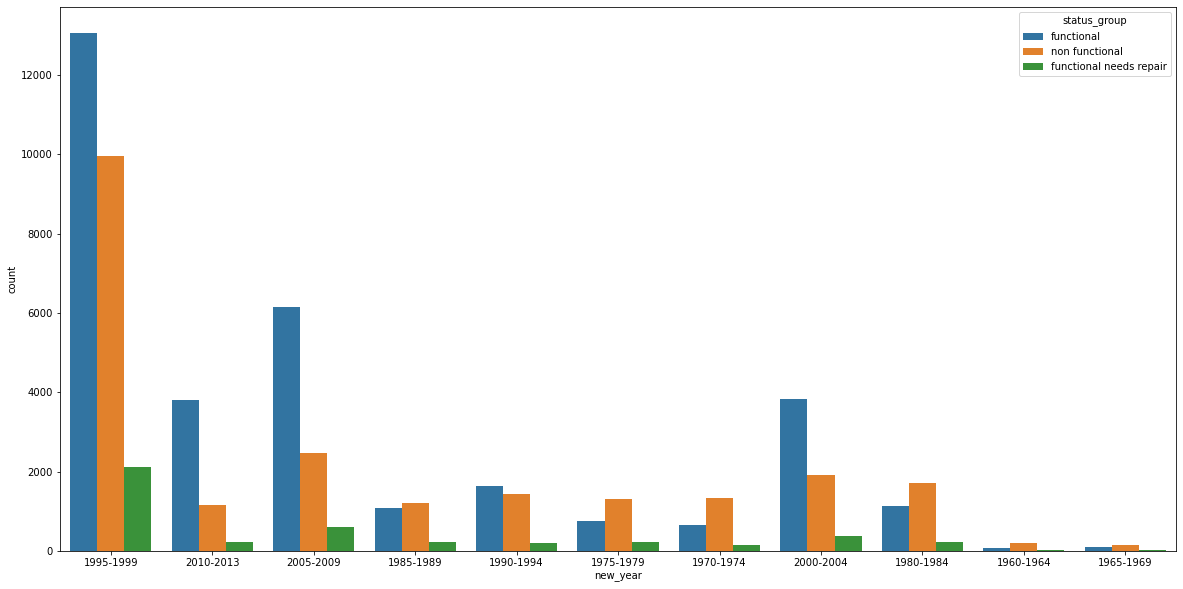

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='new_year', hue="status_group", data=df)

Apreciamos que las bombas más recientes tienen mayor probabilidad de ser funcionales.

In [ ]:
df.drop(['construction_year'], axis = 1, inplace = True)

La columna **'population'** tiene muchos valores cero, calculamos la media sin contar estos valores e imputamos este valor por los cero:

In [ ]:
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: population, Length: 1049, dtype: int64

In [ ]:
df.loc[df['population']!=0].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population
count,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000
mean,447.787681,969.889634,36.074387,-6.139781,0.740788,16.076988,6.299456,281.087167
std,3706.770967,612.544787,2.586779,2.737733,15.288297,21.597996,11.303334,564.687660
min,0.000000,-90.000000,29.607122,-11.649440,0.000000,2.000000,1.000000,1.000000
25%,0.000000,347.000000,34.715340,-8.388839,0.000000,4.000000,2.000000,40.000000
50%,0.000000,1135.000000,36.706815,-5.750877,0.000000,10.000000,3.000000,150.000000
75%,100.000000,1465.000000,37.940149,-3.597016,0.000000,16.000000,5.000000,324.000000
max,350000.000000,2770.000000,40.345193,-1.042375,1776.000000,99.000000,67.000000,30500.000000


In [ ]:
df['population'].replace(to_replace = 0 , value = 281, inplace=True)

Decidimos eliminar también **'amount_tsh'** pues está muy sesgada y tiene el 70% de valores cero:

In [ ]:
df['amount_tsh'].value_counts()/df['amount_tsh'].count()

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
6300.0      0.000017
120000.0    0.000017
138000.0    0.000017
350000.0    0.000017
59.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

In [ ]:
df.drop(['amount_tsh'], axis = 1, inplace = True)

En cuanto a **'gps_height'** que es la última variable que también tiene muchos ceros, decidimos respetarla puesto que indica la altura respecto al nivel del mar, y el cero puede ser indicativo de que la bomba de agua esté a nivel del mar justo.

### Tratamiento de columnas con valores nulos:

In [ ]:
df.isna().sum()

date_recorded          0
funder              3635
gps_height             0
installer           3655
longitude              0
latitude               0
wpt_name               0
num_private            0
basin                  0
subvillage           371
region                 0
region_code            0
district_code          0
lga                    0
ward                   0
population             0
public_meeting      3334
scheme_name        28166
permit              3056
extraction_type        0
management             0
payment_type           0
water_quality          0
quantity               0
source                 0
waterpoint_type        0
status_group           0
new_year               0
dtype: int64

La columna **'permit'** tiene 3056 valores nulos que vamos a sustituir por True ya que constituyen la mayoría.

In [ ]:
df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [ ]:
df['permit'].fillna(value=True, inplace=True)

Lo mismo ocurre con la variable **'public_meeting'**:

In [ ]:
df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [ ]:
df['public_meeting'].fillna(value=True,inplace=True)

Respecto a la columna **'subvillage'** vamos a decidir eliminarla puesto que tiene un alto número de valores únicos, y con la columna 'region' ya tenemos suficiente información sobre la ubicación:

In [ ]:
df['subvillage'].nunique()

19287

In [ ]:
df.drop(['subvillage'], axis = 1, inplace = True)

Vamos a eliminar también la variable **'num_private'** porque en la descripción oficial de las variables no sale nada de información acerca de esta, además la mayoría de los valores son ceros:

In [ ]:
df.drop(['num_private'], axis = 1, inplace = True)

Así mismo prescindimos de las columna **'scheme_name'** ya que tiene importantes fallos ortográficos que complican enormemente su reconocimiento, y su rectificación exhaustiva llevaría demasiado tiempo. Además, tiene un alto contenido de valores nulos así como valores únicos, que no nos aportarán información relevante a nuestro análisis:

In [ ]:
df['scheme_name'].nunique()

2696

In [ ]:
df['scheme_name'].value_counts().head(20)

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Losaa-Kia water supply                   152
Name: scheme_name, dtype: int64

In [ ]:
df.drop(['scheme_name'], axis = 1, inplace = True)

Vamos a sustituir los valores nulos y ceros de la variable **'installer'** por 'Unknown'. A continución veremos las 20 opciones con más frecuencia, e intentaremos corregir los principales errores ortográficos de este top para posteriormente quedarnos con solo estos 20 primeros y cambiar el resto de valores a 'Others'. Con esto eliminamos los valores nulos y ceros, y dejamos de tener tantos valores únicos, una buena solución que nos puede salvar de descartar directamente la variable:

In [ ]:
df['installer'].fillna(value='Unknown',inplace=True)
df['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True)

In [ ]:
df['installer'].value_counts().head(20)

DWE                   17402
Unknown                4435
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Name: installer, dtype: int64

In [ ]:
df['installer'].replace(to_replace = ('District Council','District council'),value ='District council' , inplace=True)
df['installer'].replace(to_replace = ('Central government', 'Government', 'Gover'),value ='District council' , inplace=True)
df['installer'].replace(to_replace = ('Commu', 'Community'),value ='Community' , inplace=True)
df['installer'].replace(to_replace = ('HESAWA', 'Hesawa'),value ='Hesawa' , inplace=True)

In [ ]:
list_installer = ['DWE','Unknown''District council','Community','RWE','DANIDA','KKKT','Hesawa','TCRS','CES','DANID','ACRA','LGA','World vision','WEDECO','TASAF','AMREF','TWESA','WU','Dmdd']
df.loc[~df['installer'].isin(list_installer), 'installer'] = 'Others'

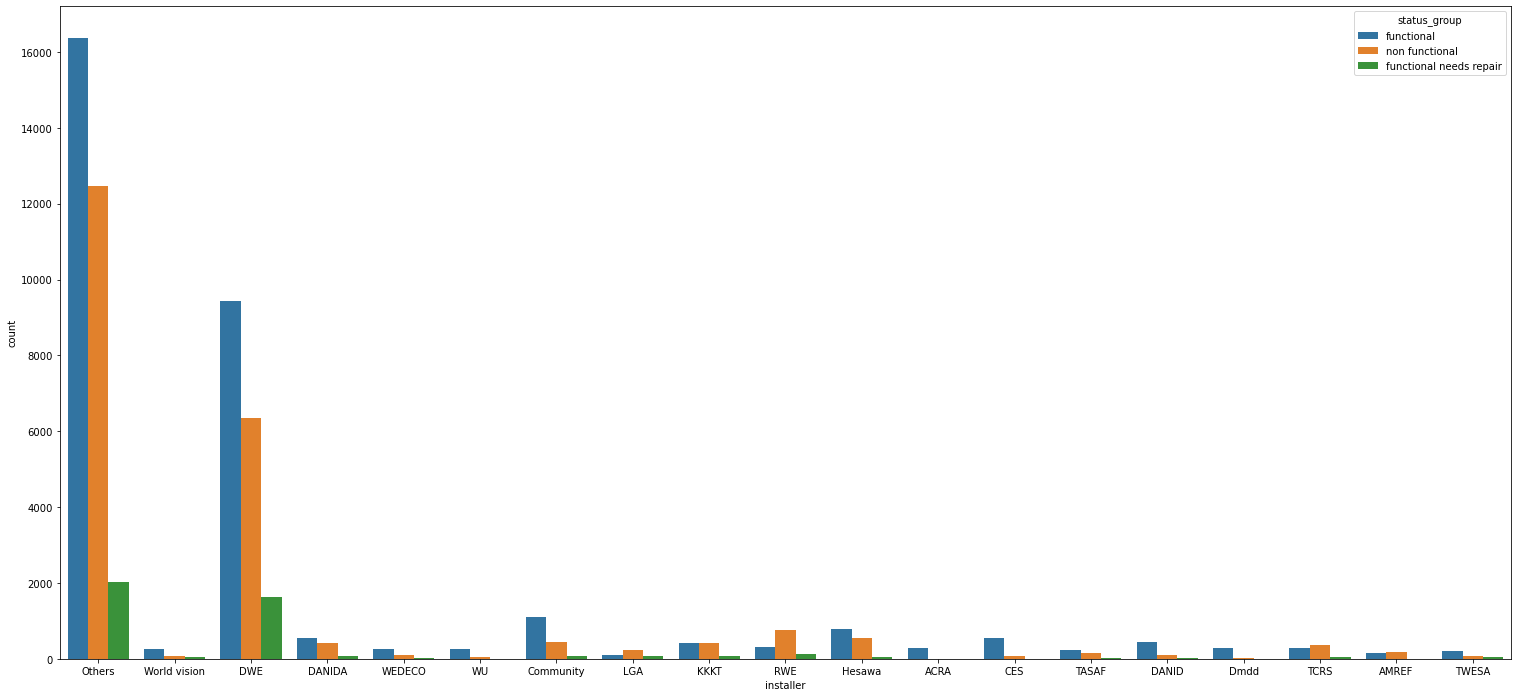

In [ ]:
plt.figure(figsize=(26,12))
ax = sns.countplot(x='installer', hue="status_group", data=df)

Con la columna **'funder'** hacemos el mismo proceso de sustitución de valores nulos y ceros. Y luego nos quedamos con el top 20, y llevamos los demás a una categoría nueva de 'Others':

In [ ]:
df['funder'].fillna(value='Unknown',inplace=True)
df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)

In [ ]:
df['funder'].value_counts().head(20)

Government Of Tanzania    9084
Unknown                   4416
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Name: funder, dtype: int64

In [ ]:
list = ['Government Of Tanzania', 'Unknown', 'Danida','Hesawa','Rwssp','World Bank','Kkkt','World Vision','Unicef','Tasaf','District Council','Dhv','Private Individual','Dwsp','Norad','Germany Republi','Tcrs','Ministry Of Water','Water','Dwe']
df.loc[~df['funder'].isin(list), 'funder'] = 'Others'

[Text(0, 0, 'Others'),
 Text(1, 0, 'Unicef'),
 Text(2, 0, 'Dwsp'),
 Text(3, 0, 'Rwssp'),
 Text(4, 0, 'Danida'),
 Text(5, 0, 'World Vision'),
 Text(6, 0, 'Hesawa'),
 Text(7, 0, 'Government Of Tanzania'),
 Text(8, 0, 'Water'),
 Text(9, 0, 'Private Individual'),
 Text(10, 0, 'Unknown'),
 Text(11, 0, 'District Council'),
 Text(12, 0, 'Kkkt'),
 Text(13, 0, 'Norad'),
 Text(14, 0, 'Dwe'),
 Text(15, 0, 'Tcrs'),
 Text(16, 0, 'Germany Republi'),
 Text(17, 0, 'Tasaf'),
 Text(18, 0, 'World Bank'),
 Text(19, 0, 'Dhv'),
 Text(20, 0, 'Ministry Of Water')]

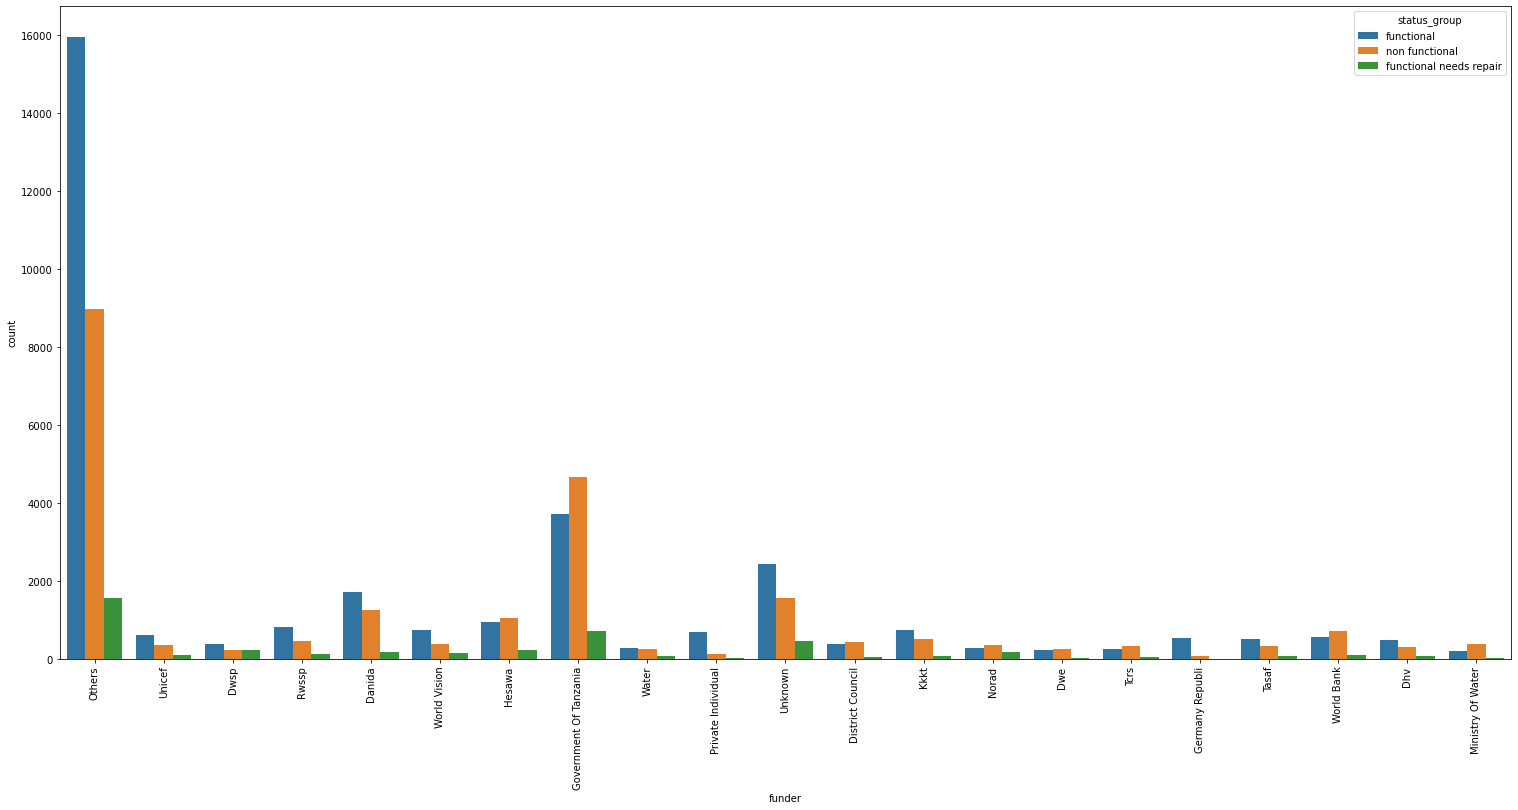

In [ ]:
plt.figure(figsize=(26,12))
ax = sns.countplot(x='funder', hue="status_group", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Tratamiento de otras columnas:

Convertimos la columna 'date_recorded' a formato fecha y creamos dos nuevas variables que incluyen el año de registro y el mes de registro. Después eliminamos la variable original:

In [ ]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

In [ ]:
df['year_recorded'] = df['date_recorded'].dt.year
df['month_recorded'] = df['date_recorded'].dt.month

In [ ]:
df.drop(['date_recorded'], axis = 1, inplace = True)

In [ ]:
df

,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,new_year,year_recorded,month_recorded
id,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,Others,1390,Others,34.938093,-9.856322,none,Lake Nyasa,Iringa,11,5,Ludewa,Mundindi,109,True,False,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,1995-1999,2011,3
8776,Others,1399,Others,34.698766,-2.147466,Zahanati,Lake Victoria,Mara,20,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2010-2013,2013,3
34310,Others,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Manyara,21,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,functional,2005-2009,2013,2
67743,Unicef,263,Others,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,1985-1989,2013,1
19728,Others,0,Others,31.130847,-1.825359,Shuleni,Lake Victoria,Kagera,18,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,1995-1999,2011,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,Pangani,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,True,gravity,water board,per bucket,soft,enough,spring,communal standpipe,functional,1995-1999,2013,5
27263,Others,1212,Others,35.249991,-9.070629,Kwa Yahona Kuvala,Rufiji,Iringa,11,4,Njombe,Ikondo,56,True,True,gravity,vwc,annually,soft,enough,river,communal standpipe,functional,1995-1999,2011,5
37057,Unknown,0,Others,34.017087,-8.750434,Mashine,Rufiji,Mbeya,12,7,Mbarali,Chimala,281,True,False,swn 80,vwc,monthly,fluoride,enough,machine dbh,hand pump,functional,1995-1999,2011,4


Después de la depuración inicial, podríamos guardar los datos en un archivo csv, y realizamos una copia del dataframe de entrenamiento final para conservar el original por si acaso.

In [ ]:
#df.to_csv('final_data_training.csv')

In [ ]:
df1 = df.copy()

### Transformación de las variables categóricas a numéricas

In [ ]:
df1.nunique()

funder                21
gps_height          2428
installer             19
longitude          57516
latitude           57517
wpt_name           37400
basin                  9
region                21
region_code           27
district_code         20
lga                  125
ward                2092
population          1048
public_meeting         2
permit                 2
extraction_type       18
management            12
payment_type           7
water_quality          8
quantity               5
source                10
waterpoint_type        7
status_group           3
new_year              11
year_recorded          5
month_recorded        12
dtype: int64

Transformamos las dos columnas booleanas a unos y ceros:

In [ ]:
df1.public_meeting.value_counts()

True     54345
False     5055
Name: public_meeting, dtype: int64

In [ ]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int)

In [ ]:
df1.permit.value_counts()

True     41908
False    17492
Name: permit, dtype: int64

In [ ]:
df1['permit'] = df1['permit'].astype(bool).astype(int)

Ahora transformamos las categóricas con menos de 10 variables manualmente:
- Inicialmente viendo los valores únicos de las variables.
- Luego creamos una lista con estos valores y otra con los valores a sustituir, que serán números.

In [ ]:
df1.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [ ]:
df1.waterpoint_type.unique()

array(['communal standpipe', 'communal standpipe multiple', 'hand pump',
       'other', 'improved spring', 'cattle trough', 'dam'], dtype=object)

In [ ]:
df1.source.unique()

array(['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other',
       'shallow well', 'river', 'hand dtw', 'lake', 'unknown'],
      dtype=object)

In [ ]:
df1.quantity.unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

In [ ]:
df1.water_quality.unique()

array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
       'salty abandoned', 'fluoride abandoned'], dtype=object)

In [ ]:
df1.payment_type.unique()

array(['annually', 'never pay', 'per bucket', 'unknown', 'on failure',
       'other', 'monthly'], dtype=object)

In [ ]:
df1.management.unique()

array(['vwc', 'wug', 'other', 'private operator', 'water board', 'wua',
       'company', 'water authority', 'parastatal', 'unknown',
       'other - school', 'trust'], dtype=object)

In [ ]:
df1.basin.unique()

array(['Lake Nyasa', 'Lake Victoria', 'Pangani',
       'Ruvuma / Southern Coast', 'Internal', 'Lake Tanganyika',
       'Wami / Ruvu', 'Rufiji', 'Lake Rukwa'], dtype=object)

In [ ]:
df1.new_year.unique()

array(['1995-1999', '2010-2013', '2005-2009', '1985-1989', '1990-1994',
       '1975-1979', '1970-1974', '2000-2004', '1980-1984', '1960-1964',
       '1965-1969'], dtype=object)

In [ ]:
df1.waterpoint_type.replace(('communal standpipe', 'communal standpipe multiple', 'hand pump',
                       'other', 'improved spring', 'cattle trough', 'dam'),
                      (1,2,3,4,5,6,7),inplace=True)

df1.source.replace(('spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other',
                     'shallow well', 'river', 'hand dtw', 'lake', 'unknown'),
                      (1,2,3,4,5,6,7,8,9,10),inplace=True)

df1.quantity.replace(('enough', 'insufficient', 'dry', 'seasonal', 'unknown'),
                      (1,2,3,4,5),inplace=True)

df1.water_quality.replace(('soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
                      'salty abandoned', 'fluoride abandoned'),
                      (1,2,3,4,5,6,7,8),inplace=True)

df1.payment_type.replace(('annually', 'never pay', 'per bucket', 'unknown', 'on failure',
                      'other', 'monthly'),
                      (1,2,3,4,5,6,7),inplace=True)

df1.management.replace(('vwc', 'wug', 'other', 'private operator', 'water board', 'wua',
                           'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust'),
                      (1,2,3,4,5,6,7,8,9,10,11,12),inplace=True)

df1.basin.replace(('Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma / Southern Coast',
                   'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Rufiji', 'Lake Rukwa'),
                      (1,2,3,4,5,6,7,8,9),inplace=True)

df1.new_year.replace(('1995-1999', '2010-2013', '2005-2009', '1985-1989', '1990-1994', '1975-1979',
                      '1970-1974', '2000-2004', '1980-1984', '1960-1964', '1965-1969'),
                      (1,2,3,4,5,6,7,8,9,10,11),inplace=True)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   funder           59400 non-null  object 
 1   gps_height       59400 non-null  int64  
 2   installer        59400 non-null  object 
 3   longitude        59400 non-null  float64
 4   latitude         59400 non-null  float64
 5   wpt_name         59400 non-null  object 
 6   basin            59400 non-null  int64  
 7   region           59400 non-null  object 
 8   region_code      59400 non-null  int64  
 9   district_code    59400 non-null  int64  
 10  lga              59400 non-null  object 
 11  ward             59400 non-null  object 
 12  population       59400 non-null  int64  
 13  public_meeting   59400 non-null  int32  
 14  permit           59400 non-null  int32  
 15  extraction_type  59400 non-null  object 
 16  management       59400 non-null  int64  
 17  payment_

Ahora transformamos con 'LabelEncoder' el resto de las variables tipo objeto para convertir todas a numéricas:

In [ ]:
le = LabelEncoder()

Mostramos un ejemplo con la columna 'funder' del proceso que vamos a realizar con todas las variables tipo objeto:

In [ ]:
le.fit(df1.funder.unique())
le.classes_

array(['Danida', 'Dhv', 'District Council', 'Dwe', 'Dwsp',
       'Germany Republi', 'Government Of Tanzania', 'Hesawa', 'Kkkt',
       'Ministry Of Water', 'Norad', 'Others', 'Private Individual',
       'Rwssp', 'Tasaf', 'Tcrs', 'Unicef', 'Unknown', 'Water',
       'World Bank', 'World Vision'], dtype=object)

In [ ]:
df1.funder.head()

id
69572    Others
8776     Others
34310    Others
67743    Unicef
19728    Others
Name: funder, dtype: object

In [ ]:
le.transform(df1.funder)

array([11, 11, 11, ..., 17, 11, 19])

In [ ]:
df1.funder = le.transform(df1.funder)

In [ ]:
df1.funder.head()

id
69572    11
8776     11
34310    11
67743    16
19728    11
Name: funder, dtype: int32

In [ ]:
df1.installer = le.fit_transform(df1.installer)
df1.wpt_name = le.fit_transform(df1.wpt_name)
df1.region = le.fit_transform(df1.region)
df1.lga = le.fit_transform(df1.lga)
df1.ward = le.fit_transform(df1.ward)
df1.extraction_type = le.fit_transform(df1.extraction_type)

In [ ]:
#df1.to_csv('train_limpio_final.csv')
#Si queremos realizar copia en csv del dataframe final de entrenamiento con todo limpio y todas las variables numéricas

Ahora todas las columnas son numéricas:

In [ ]:
df1

,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,new_year,year_recorded,month_recorded
id,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,11,1390,11,34.938093,-9.856322,37399,1,3,11,5,51,1426,109,1,0,3,1,1,1,1,1,1,functional,1,2011,3
8776,11,1399,11,34.698766,-2.147466,37195,2,9,20,2,103,1576,280,1,1,3,2,2,1,2,2,1,functional,2,2013,3
34310,11,686,18,37.460664,-3.821329,14572,3,8,21,4,108,1624,250,1,1,3,1,3,1,1,3,2,functional,3,2013,2
67743,16,263,11,38.486161,-11.155298,37285,4,12,90,63,87,1571,58,1,1,14,1,2,1,3,4,2,non functional,4,2013,1
19728,11,0,11,31.130847,-1.825359,35529,2,4,18,1,26,1687,281,1,1,3,3,2,1,4,2,1,functional,1,2011,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,5,1210,2,37.169807,-3.253847,513,3,6,3,5,16,1090,125,1,1,3,5,3,1,1,1,1,functional,1,2013,5
27263,11,1212,11,35.249991,-9.070629,24074,8,3,11,4,91,353,56,1,1,3,1,1,1,1,7,1,functional,1,2011,5
37057,17,0,11,34.017087,-8.750434,27926,8,10,12,7,59,177,281,1,0,15,1,7,5,1,4,3,functional,1,2011,4


### Aplicamos las mismas transformaciones que hemos aplicado al training al df de test:

In [ ]:
df_test = pd.read_csv("test_set_values.csv")
df_test.drop(['quantity_group',
        'management_group',
        'scheme_management',
        'source_type',
        'source_class',
        'quantity_group',
        'waterpoint_type_group',
        'extraction_type_class',
        'scheme_name',
        'quality_group',
        'payment',
        'recorded_by',], axis = 1, inplace = True)
df_test = df_test.assign(new_year = df_test['construction_year'])
df_test['new_year'].replace(to_replace = 0, value = 1996, inplace=True)
df_test['new_year'].replace(to_replace = (1960,1961,1962,1963,1964),
                        value ='1960-1964' , inplace=True)
df_test['new_year'].replace(to_replace = (1965,1966,1967,1968,1969),
                        value ='1965-1969' , inplace=True)
df_test['new_year'].replace(to_replace = (1970,1971,1972,1973,1974),
                        value ='1970-1974' , inplace=True)
df_test['new_year'].replace(to_replace = (1975,1976,1977,1978,1979),
                        value ='1975-1979' , inplace=True)
df_test['new_year'].replace(to_replace = (1980,1981,1982,1983,1984),
                        value ='1980-1984' , inplace=True)
df_test['new_year'].replace(to_replace = (1985,1986,1987,1988,1989),
                        value ='1985-1989' , inplace=True)
df_test['new_year'].replace(to_replace = (1990,1991,1992,1993,1994),
                        value ='1990-1994' , inplace=True)
df_test['new_year'].replace(to_replace = (1995,1996,1997,1998,1999),
                        value ='1995-1999' , inplace=True)
df_test['new_year'].replace(to_replace = (2000,2001,2002,2003,2004),
                        value ='2000-2004' , inplace=True)
df_test['new_year'].replace(to_replace = (2005,2006,2007,2008,2009),
                        value ='2005-2009' , inplace=True)
df_test['new_year'].replace(to_replace = (2010,2011,2012,2013),
                        value ='2010-2013' , inplace=True)
df_test['population'].replace(to_replace = 0 , value = 281, inplace=True)
df_test['permit'].fillna(value=True, inplace=True)
df_test['public_meeting'].fillna(value=True,inplace=True)
df_test['installer'].fillna(value='Unknown',inplace=True)
df_test['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True)
df_test['installer'].replace(to_replace = ('District Council','District council'),value ='District council' , inplace=True)
df_test['installer'].replace(to_replace = ('Central government', 'Government', 'Gover'),value ='District council' , inplace=True)
df_test['installer'].replace(to_replace = ('Commu', 'Community'),value ='Community' , inplace=True)
df_test['installer'].replace(to_replace = ('HESAWA', 'Hesawa'),value ='Hesawa' , inplace=True)
list_installer = ['DWE','Unknown''District council','Community','RWE','DANIDA','KKKT','Hesawa','TCRS','CES','DANID','ACRA','LGA','World vision','WEDECO','TASAF','AMREF','TWESA','WU','Dmdd']
df_test.loc[~df_test['installer'].isin(list_installer), 'installer'] = 'Others'
df_test['funder'].fillna(value='Unknown',inplace=True)
df_test['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)
list = ['Government Of Tanzania', 'Unknown', 'Danida','Hesawa','Rwssp','World Bank','Kkkt','World Vision','Unicef','Tasaf','District Council','Dhv','Private Individual','Dwsp','Norad','Germany Republi','Tcrs','Ministry Of Water','Water','Dwe']
df_test.loc[~df_test['funder'].isin(list), 'funder'] = 'Others'
df_test['date_recorded'] = pd.to_datetime(df_test['date_recorded'])
df_test['year_recorded'] = df_test['date_recorded'].dt.year
df_test['month_recorded'] = df_test['date_recorded'].dt.month
df_test['permit'] = df_test['permit'].astype(bool).astype(int)
df_test['public_meeting'] = df_test['public_meeting'].astype(bool).astype(int)
df_test.waterpoint_type.replace(('communal standpipe', 'communal standpipe multiple', 'hand pump',
                       'other', 'improved spring', 'cattle trough', 'dam'),
                      (1,2,3,4,5,6,7),inplace=True)
df_test.source.replace(('spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other',
                     'shallow well', 'river', 'hand dtw', 'lake', 'unknown'),
                      (1,2,3,4,5,6,7,8,9,10),inplace=True)
df_test.quantity.replace(('enough', 'insufficient', 'dry', 'seasonal', 'unknown'),
                      (1,2,3,4,5),inplace=True)
df_test.water_quality.replace(('soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
                      'salty abandoned', 'fluoride abandoned'),
                      (1,2,3,4,5,6,7,8),inplace=True)
df_test.payment_type.replace(('annually', 'never pay', 'per bucket', 'unknown', 'on failure',
                      'other', 'monthly'),
                      (1,2,3,4,5,6,7),inplace=True)
df_test.management.replace(('vwc', 'wug', 'other', 'private operator', 'water board', 'wua',
                           'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust'),
                      (1,2,3,4,5,6,7,8,9,10,11,12),inplace=True)
df_test.basin.replace(('Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma / Southern Coast',
                   'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Rufiji', 'Lake Rukwa'),
                      (1,2,3,4,5,6,7,8,9),inplace=True)
df_test.new_year.replace(('1995-1999', '2010-2013', '2005-2009', '1985-1989', '1990-1994', '1975-1979',
                      '1970-1974', '2000-2004', '1980-1984', '1960-1964', '1965-1969'),
                      (1,2,3,4,5,6,7,8,9,10,11),inplace=True)
df_test.drop(['date_recorded',
        'num_private',
        'subvillage',
        'amount_tsh',
        'construction_year',
        'extraction_type_group'], axis = 1, inplace = True)
le = LabelEncoder()
df_test.funder = le.fit_transform(df_test.funder)
df_test.installer = le.fit_transform(df_test.installer)
df_test.wpt_name = le.fit_transform(df_test.wpt_name)
df_test.region = le.fit_transform(df_test.region)
df_test.lga = le.fit_transform(df_test.lga)
df_test.ward = le.fit_transform(df_test.ward)
df_test.extraction_type = le.fit_transform(df_test.extraction_type)

In [ ]:
#df_test.to_csv('test_limpio.csv') #Si queremos exportar el test limpio en csv

## Elección de modelo

Utilizamos la librería pycaret para ver una primera aproximación de qué tipo de modelos serán más útiles.

In [ ]:
import pycaret
from pycaret.classification import *

In [ ]:
#Desactivo las celdas porque si se ejecuta todo el notebook de una vez tardaría demasiado en terminar, muestro solo resultados

In [ ]:
#model_setup = setup(data=df1, target='status_group', session_id=1)

In [ ]:
#models()

In [ ]:
#best_models = compare_models()

Vemos claramente que la mejor opción será la de utilizar RandomForest, así que vamos a ello!

## Propuesta de modelos

Realizamos la partición training-test con el dataframe final de los datos de training:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split (df1.drop('status_group', axis=1),
                                                     df1.status_group,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     shuffle = True)

Probamos a ejecutar el modelo con RandomForestClassifier y ver sus métricas:

In [ ]:
model1 = RandomForestClassifier().fit(X_train,y_train)
y_pred = model1.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6444
functional needs repair       0.58      0.33      0.42       867
         non functional       0.83      0.78      0.81      4569

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



Probamos a tunear los hiperparámetros:

In [ ]:
grid_param = {
    'n_estimators': [30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [20,22,24]
}

In [ ]:
model_grid = GridSearchCV(estimator=model1,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

In [ ]:
#model_grid.fit(X_train, y_train) #celdas desactivadas para poder ejecutar el notebook sin perder mucho tiempo

In [ ]:
#print(model_grid.best_params_)

In [ ]:
#print(model_grid.best_score_)

Obtenemos que los mejores parámetros son: bootstrap=True, criterion='gini', max_depth=20, n_estimators=30.

Lo probamos en un nuevo modelo:

In [ ]:
model2 = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20, n_estimators=30).fit(X_train,y_train)
y_pred = model2.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6444
functional needs repair       0.63      0.29      0.40       867
         non functional       0.85      0.77      0.81      4569

               accuracy                           0.81     11880
              macro avg       0.76      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



Comprobamos que los resultados son realmente muy parecidos, y tras lanzar ambos modelos en la página del concurso la nota de subida sin tunear los hiperparámetros en la predicción final es sensiblemente mejor, así que utilizaremos las opciones por defecto.

In [ ]:
#df_test = pd.read_csv("test_clean.csv")

Comprobamos los dataframes de test y training para ver si tienen columnas diferentes:

In [ ]:
df1

,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,new_year,year_recorded,month_recorded
id,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,11,1390,11,34.938093,-9.856322,37399,1,3,11,5,51,1426,109,1,0,3,1,1,1,1,1,1,functional,1,2011,3
8776,11,1399,11,34.698766,-2.147466,37195,2,9,20,2,103,1576,280,1,1,3,2,2,1,2,2,1,functional,2,2013,3
34310,11,686,18,37.460664,-3.821329,14572,3,8,21,4,108,1624,250,1,1,3,1,3,1,1,3,2,functional,3,2013,2
67743,16,263,11,38.486161,-11.155298,37285,4,12,90,63,87,1571,58,1,1,14,1,2,1,3,4,2,non functional,4,2013,1
19728,11,0,11,31.130847,-1.825359,35529,2,4,18,1,26,1687,281,1,1,3,3,2,1,4,2,1,functional,1,2011,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,5,1210,2,37.169807,-3.253847,513,3,6,3,5,16,1090,125,1,1,3,5,3,1,1,1,1,functional,1,2013,5
27263,11,1212,11,35.249991,-9.070629,24074,8,3,11,4,91,353,56,1,1,3,1,1,1,1,7,1,functional,1,2011,5
37057,17,0,11,34.017087,-8.750434,27926,8,10,12,7,59,177,281,1,0,15,1,7,5,1,4,3,functional,1,2011,4


In [ ]:
df_test

,id,funder,gps_height,installer,longitude,latitude,wpt_name,basin,region,region_code,district_code,lga,ward,population,public_meeting,permit,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,new_year,year_recorded,month_recorded
0,50785,11,1996,11,35.290799,-4.059696,656,5,8,21,3,63,17,321,1,1,9,9,2,1,4,2,4,2,2013,2
1,51630,6,1569,6,36.656709,-3.309214,1780,3,0,2,2,0,650,300,1,1,3,1,2,1,2,1,1,8,2013,2
2,17168,17,1567,11,34.767863,-5.004344,9673,5,18,13,2,109,1677,500,1,1,9,1,2,1,2,2,4,2,2013,2
3,45559,11,267,11,38.058046,-9.418672,5595,4,7,80,43,49,1192,250,1,1,9,1,4,1,3,6,4,4,2013,1
4,49871,11,1260,11,35.006123,-10.950412,5706,4,16,10,3,61,1075,60,1,1,3,5,7,1,1,1,1,8,2013,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0,34,11,38.852669,-6.582841,7223,7,14,6,1,3,1948,20,1,1,7,1,2,1,1,7,1,4,2011,2
14846,18990,11,0,11,37.451633,-5.350428,332,3,20,4,7,33,1350,2960,1,0,8,1,1,2,2,6,3,5,2011,3
14847,28749,17,1476,11,34.739804,-4.585587,457,5,18,13,2,109,1868,200,1,1,3,1,2,1,2,3,1,2,2013,3
14848,33492,11,998,6,35.432732,-10.584159,3438,1,16,10,2,111,998,150,1,1,3,1,2,1,2,7,1,3,2013,2


In [ ]:
df1.shape, df_test.shape

((59400, 26), (14850, 26))

In [ ]:
df1.columns.difference(df_test.columns)

Index(['status_group'], dtype='object')

Ajustamos los datos de training a los de test para obtener la predicción final:

In [ ]:
X_test = df_test.drop(columns = ['id']).values
model_predict = RandomForestClassifier().fit(X_train,y_train)
y_pred_final = model_predict.predict(X_test)

In [ ]:
pred_final = pd.DataFrame(y_pred_final)

In [ ]:
pred_final.head()

,0
0,non functional
1,functional
2,functional
3,non functional
4,functional


In [ ]:
df_test.shape, pred_final.shape

((14850, 26), (14850, 1))

Creamos el dataframe final uniendo la columna 'id' del test con las predicciones creadas y vemos qué pinta tiene:

In [ ]:
prediccion = pd.concat((df_test['id'], pred_final), axis=1)

In [ ]:
prediccion.columns=['id', 'status_group']

In [ ]:
prediccion.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


Exportamos este dataframe final en csv:

In [ ]:
#prediccion.to_csv('subida_final.csv', index=False)

# LA SUBIDA HA OBTENIDO UNA PUNTUACIÓN DE 0.8133 EN EL CONCURSO DE 'Pump it Up: Data Mining the Water Table' HOSTED BY DRIVENDATA

## Otras subidas a la plataforma del concurso

Se prueban las siguientes transformaciones y se comprueba con la correspondiente subida a la página del concurso.

(No he mostrado el código pertinente a cada una, pues lo he ejecutado en notebooks diferentes a los cuales iba haciendo copias. Además al ser transformaciones en mitad del notebook pienso que dificultaría la visión final limpia del proceso en el que he obtenido mejor puntuación).

- Se tunean los hiperparámetros del random forest de la predicción igual que la mejor opción del tuneo del training: resultado -> **0.8116**

- Se eliminan las variables con mayor número de valores únicos que son 'wpt_name', 'longitude' y 'latitude': resultado -> **0.8015**, lo que nos indica que sí que son significativas y aportan más puntuación al modelo

- Se aplica MinMaxScaler a las columnas numéricas tanto del dataframe del training como del test pero sorprendentemente reduce el score a **0.8040**

- Aplicando StandardScaler a las columnas numéricas también reduce muchísimo el score a **0.7135**

- Se prueban a eliminar las columnas 'lga' y 'ward'pues tienen a priori la misma información que 'region': resultado -> **0.8093**

- La última prueba consistió en transformar en dummies las variables categóricas con formato objeto y menos número de valores únicos, como son 'funder', 'installer', 'region' y 'extraction_type', pero el score no mejoro, quedándose con **0.8119**

- Balanceando los datos mediante la técnica de OverSampling con SMOTE desciende el score a **0.7938** lo que nos puede dar indicios de que en este caso los el modelo estaba sobreajustado a los datos de training.

- Si se modela con XGBClassifier y se tunean los hiperparámetros para obtener los mejores, la nota que da el dataframe final es de **0.7980**

- Se acaba eligiendo este código, ya que el anterior con mejor puntuación (**0.8131**) no tenía activada la función de 'shuffle' al crear la separación de los datos de training para el entrenamiento; en cambio tenía activada la de 'stratify' según la variable 'status_group'.

- Y alguna otra modificación menor que no consiguió mejorar el de este notebook final.